## Modeling - Citation Prediction

In [1]:
# basic
import sys
import os
import json
import pdb
import ast
import time
import requests
from tqdm import tqdm
from collections import Counter, defaultdict, namedtuple

# debug
import pdb
from loguru import logger

import numpy as np
import pandas as pd

# plotting
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

# sklearn
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import metrics

# regression models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
import xgboost
from xgboost.sklearn import XGBRegressor

# classification models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

# from warnings import filterwarnings
# filterwarnings(action='ignore', category=DeprecationWarning,  message='`np.bool` is a deprecated alias')
# filterwarnings(action='ignore', category=DeprecationWarning,  message='`np.int` is a deprecated alias' )
# filterwarnings(action='ignore', category=DeprecationWarning,  message='`np.object` is a deprecated alias')


# custom
from utils import *
# from parser import work_parser, author_parser, venue_parser, institution_parser
# from scraper import oa_work_scraper, oa_author_scraper

SEED = 0

/Users/gautamchoudhary/miniconda3/envs/myenv/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/gautamchoudhary/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Load Data

In [2]:
YEAR = 2017

works = pd.read_csv(f'./data/{YEAR}/works.{YEAR}.v1.csv', index_col='id')
authors = pd.read_csv(f'./data/{YEAR}/authors.{YEAR}.v1.csv', index_col='id')
venues = pd.read_csv(f'./data/{YEAR}/venues.{YEAR}.v1.csv', index_col='id')
insts = pd.read_csv(f'./data/{YEAR}/insts.{YEAR}.v1.csv', index_col='id')

In [4]:
%%time
works = preprocess_works(works, YEAR, 2022)

CPU times: user 9.54 s, sys: 371 ms, total: 9.91 s
Wall time: 9.94 s


((145531, 14), 145531)

In [5]:
print (f'works \n - shape={works.shape} \n - columns={works.columns.tolist()} \n\n')
print (f'authors \n - shape={authors.shape} \n - columns={authors.columns.tolist()} \n\n')
print (f'venues \n - shape={venues.shape} \n - columns={venues.columns.tolist()} \n\n')
print (f'insts \n - shape={insts.shape} \n - columns={insts.columns.tolist()} \n\n')

works 
 - shape=(145531, 14) 
 - columns=['doi', 'title', 'type', 'publication_date', 'host_venue', 'open_access_is_oa', 'open_access_oa_status', 'authorships', 'page_count', 'cited_by_count', 'concepts', 'referenced_works', 'abstract', 'counts_by_year'] 


authors 
 - shape=(344470, 7) 
 - columns=['orcid', 'display_name', 'works_count', 'cited_by_count', 'created_date', 'concepts', 'counts_by_year'] 


venues 
 - shape=(1854, 8) 
 - columns=['display_name', 'works_count', 'cited_by_count', 'is_oa', 'type', 'created_date', 'concepts', 'counts_by_year'] 


insts 
 - shape=(13227, 10) 
 - columns=['display_name', 'country_code', 'type', 'homepage_url', 'works_count', 'cited_by_count', 'associated_institutions', 'concepts', 'counts_by_year', 'created_date'] 




In [7]:
# works
print (works.shape)
works.head()

(145531, 14)


,doi,title,type,publication_date,host_venue,open_access_is_oa,open_access_oa_status,authorships,page_count,cited_by_count,concepts,referenced_works,abstract,counts_by_year
id,,,,,,,,,,,,,,
W2555618208,https://doi.org/10.1109/cvpr.2017.691,Multi-view 3D Object Detection Network for Aut...,proceedings-article,2017-07-21,V4306417987,True,green,"[[A2119051707, [I99065089]], [A2151001937, [I9...",-1,1409,"[[C131979681, 0.86888766], [C41008148, 0.77201...","[W7746136, W1536680647, W1914646313, W19466097...",This paper aims at high-accuracy 3D object det...,"[(2017, 13), (2018, 109), (2019, 308), (2020, ..."
W2557641257,https://doi.org/10.1109/cvpr.2017.733,ECO: Efficient Convolution Operators for Tracking,proceedings-article,2017-07-21,V4306417987,True,green,"[[A260882311, [I102134673]], [A2557978175, [I1...",-1,1322,"[[C63479239, 0.8030945], [C68339613, 0.7788200...","[W1857884451, W1892578678, W1904671147, W19157...","In recent years, Discriminative Correlation Fi...","[(2017, 9), (2018, 133), (2019, 303), (2020, 3..."
W2963709863,https://doi.org/10.1109/cvpr.2017.241,Learning from Simulated and Unsupervised Image...,proceedings-article,2017-07-21,V4306417987,True,green,"[[A2183241032, [I1311269955]], [A2798413642, [...",-1,1277,"[[C41008148, 0.8212265], [C2779803651, 0.78661...","[W1922126009, W1950149599, W1995694455, W20012...","With recent progress in graphics, it has becom...","[(2017, 55), (2018, 251), (2019, 356), (2020, ..."
W2594519801,https://doi.org/10.1109/cvpr.2017.261,ScanNet: Richly-Annotated 3D Reconstructions o...,proceedings-article,2017-07-21,V4306417987,True,green,"[[A2158018495, [I97018004]], [A2111957820, [I2...",-1,1116,"[[C41008148, 0.8516614], [C82990744, 0.6491697...","[W218762409, W1509835260, W1565402342, W159436...",A key requirement for leveraging supervised de...,"[(2017, 12), (2018, 76), (2019, 226), (2020, 3..."
W2561715562,https://doi.org/10.1109/cvpr.2017.215,CLEVR: A Diagnostic Dataset for Compositional ...,proceedings-article,2017-07-01,V4306417987,True,green,"[[A2345205178, [I97018004]], [A1988254826, [I2...",-1,1085,"[[C41008148, 0.7745689], [C130440534, 0.751482...","[W1933349210, W1983927101, W1996418862, W20646...",When building artificial intelligence systems ...,"[(2017, 38), (2018, 146), (2019, 232), (2020, ..."


In [8]:
# works['page_count'].unique()
# # TODO: error
# works[works['page_count']=='(10,)']

### Feature Extraction

In [11]:
def bin_citations(cc):
    if cc < 50:
        return 0
    else:
        return 1


def get_features(works, authors, venues, insts):
    '''
    Feature generate given the data for both regression and classification
    '''
    df = pd.DataFrame()

    # `WORK`: Paper meta-data features
    df['no_of_authors'] = works['authorships'].map(lambda x: len(x))
    df['no_of_referenced_works'] = works['referenced_works'].map(len)
    df['open_access_is_oa'] = works['open_access_is_oa']
    df['publication_month'] = works['publication_date'].map(lambda x: int(x.split('-')[1]))
    # df['page_count'] = works['page_count'].map(lambda x: x if isinstance(x, int ) else x[0])

    # `AUTHOR`: Author-specific Features
    thresh_author_citation_prominent = authors['cited_by_count'].mean()
    author_citation = defaultdict(lambda: 0, authors['cited_by_count'].to_dict())
    df['author_prominency'] = works['authorships'].map(lambda x: 1 if max([author_citation[i[0]] for i in x]) >= thresh_author_citation_prominent else 0)
    df['authors_mean_citations'] = works['authorships'].map(lambda x: np.mean([author_citation[i[0]] for i in x]))
    author_work_count = defaultdict(lambda: 0, authors['works_count'].to_dict())
    df['authors_mean_works'] = works['authorships'].map(lambda x: np.mean([author_work_count[i[0]] for i in x]))

    # `VENUE`: Journal and Publisher relevant features
    venue_significance = defaultdict(lambda: 0, (venues['cited_by_count']/venues['works_count']).to_dict())
    df['venue_significance'] = works['host_venue'].map(lambda x: venue_significance[x])
    venue_works = defaultdict(lambda: 0, venues['works_count'].to_dict())
    df['venue_works'] = works['host_venue'].map(lambda x: venue_works[x])
    venue_citations = defaultdict(lambda: 0, venues['cited_by_count'].to_dict())
    df['venue_citations'] = works['host_venue'].map(lambda x: venue_citations[x])

    # `INSTITUTION`: Insti-specific Features
    insts_citation = defaultdict(lambda: 0, insts['cited_by_count'].to_dict())
    df['insts_mean_citations'] = works['authorships'].map(
        lambda x: np.mean([insts_citation[i[1][0]] for i in x if len(i[1])>0], ))
    insts_work_count = defaultdict(lambda: 0, insts['works_count'].to_dict())
    df['insts_mean_works'] = works['authorships'].map(lambda x: np.mean([insts_work_count[i[1][0]] for i in x if len(i[1])>0]))    
    
    # TODO: needs to be corrected
    df.fillna(0, inplace=True)
    
    # target variable
    df['y_reg'] = works['cited_by_count']
    df['y_clf'] = works['cited_by_count'].map(bin_citations)
    
    return df

df = get_features(works, authors, venues, insts)

/Users/gautamchoudhary/miniconda3/envs/myenv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/gautamchoudhary/miniconda3/envs/myenv/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/gautamchoudhary/miniconda3/envs/myenv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/gautamchoudhary/miniconda3/envs/myenv/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


### Regression

In [12]:
X = df.drop(columns=['y_reg', 'y_clf'])
y = df['y_reg']

In [13]:
# train - test split
TEST_SIZE = 0.2
train_index, test_index = train_test_split(range(len(X)), test_size=TEST_SIZE, random_state=SEED)

X_train, X_test = X.iloc[train_index], X.iloc[test_index]
y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [14]:
# normalize
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

In [15]:
# regression analysis

reg_models = {
    'Linear Regression': LinearRegression(n_jobs=-1),
    # 'GradientBoostingRegressor': GradientBoostingRegressor(random_state=SEED),
    # 'SGDRegressor': SGDRegressor(random_state=SEED),
    # 'XGBRegressor': XGBRegressor(random_state=SEED),
    # 'MLPRegressor': MLPRegressor(random_state=SEED, max_iter=100),
}

def eval_regression(model, X_train, X_test, y_train, y_test):
    # model eval
    y_pred = model.predict(X_train)
    rmse = metrics.mean_squared_error(y_true=y_train, y_pred=y_pred, squared=False)
    print (f"  - Train RMSE: {rmse}")
    mae = metrics.mean_absolute_error(y_true=y_train, y_pred=y_pred)
    print (f"  - Train MAE: {mae}")
    r2 = metrics.r2_score(y_true=y_train, y_pred=y_pred)
    print (f"  - Train R^2: {r2}")
    
    y_pred = model.predict(X_test)
    rmse = metrics.mean_squared_error(y_true=y_test, y_pred=y_pred, squared=False)
    print (f"  - Test RMSE: {rmse}")
    mae = metrics.mean_absolute_error(y_true=y_test, y_pred=y_pred)
    print (f"  - Test MAE: {mae}")
    r2 = metrics.r2_score(y_true=y_test, y_pred=y_pred)
    print (f"  - Test R^2: {r2}")
    
    return
    
for model_name, model in reg_models.items():
    # model train
    model.fit(scaler.transform(X_train), y_train)

    print (f"{model_name}:")
    eval_regression(model, scaler.transform(X_train), scaler.transform(X_test),
                   y_train, y_test)

Linear Regression:
  - Train RMSE: 19.453143382799702
  - Train MAE: 6.2006124043107285
  - Train R^2: 0.16738274610321702
  - Test RMSE: 18.64936500995852
  - Test MAE: 6.228246454761046
  - Test R^2: 0.17747766434155487


Feature: 0  Score: ('authors_mean_citations', 5.751867497566439)
Feature: 1  Score: ('venue_significance', 4.979015959289447)
Feature: 2  Score: ('venue_citations', 2.025356563349965)
Feature: 3  Score: ('open_access_is_oa', 1.617259564389656)
Feature: 4  Score: ('no_of_referenced_works', 1.1576108052551792)
Feature: 5  Score: ('venue_works', 1.02558992997215)
Feature: 6  Score: ('insts_mean_citations', 0.9069861206555837)
Feature: 7  Score: ('no_of_authors', 0.7672324285036338)
Feature: 8  Score: ('author_prominency', 0.5741108384946237)
Feature: 9  Score: ('publication_month', -0.07539146287832424)
Feature: 10  Score: ('insts_mean_works', -0.7967801312729459)
Feature: 11  Score: ('authors_mean_works', -4.8001720603971005)


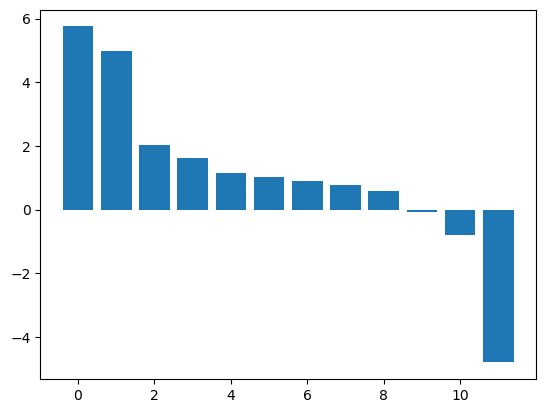

In [16]:
# get importance for linear regression
importance = model.coef_
indices = np.argsort(importance)[::-1]
for i,v in enumerate(zip(X.columns[indices], importance[indices])):
    print('Feature: {}  Score: {}' .format(i,v))

# plot feature importance
plt.bar([x for x in range(len(importance))], importance[indices])
plt.show()

### Classification

In [17]:
X = df.drop(columns=['y_reg', 'y_clf'])
y = df['y_clf']

In [18]:
y.value_counts(normalize=True)

0    0.984244
1    0.015756
Name: y_clf, dtype: float64

In [19]:
# train - test split
TEST_SIZE = 0.2
train_index, test_index = train_test_split(range(len(X)), test_size=TEST_SIZE, random_state=SEED)

X_train, X_test = X.iloc[train_index], X.iloc[test_index]
y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [20]:
# normalize
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

In [21]:
# classification analysis

clf_models = {
    'LogisticRegression': LogisticRegression(random_state=SEED, n_jobs=-1),
    # 'XGBoost': xgboost.XGBClassifier(random_state=SEED),
    # 'KNeighborsClassifier': KNeighborsClassifier(n_jobs=-1),
    # 'GaussianNB': GaussianNB(),
    # 'DecisionTreeClassifier': DecisionTreeClassifier(random_state=SEED),
    # 'SVC': SVC(random_state=SEED, max_iter=100, probability=True),
    # 'MLPClassifier': MLPClassifier(random_state=SEED, max_iter=100),
}

def eval_classification(model, X_train, X_test, y_train, y_test):
    # model eval
    y_pred = model.predict(X_train)
    y_pred_proba = model.predict_proba(X_train)[:, 1]
    acc = metrics.accuracy_score(y_true=y_train, y_pred=y_pred)
    print (f'  - Train Accuracy (in %): {acc}')
    f1 = metrics.f1_score(y_true=y_train, y_pred=y_pred, average='weighted')
    print (f'  - Train F1: {f1}')
    auc = metrics.roc_auc_score(y_true=y_train, y_score=y_pred_proba, average='weighted')
    print (f'  - Train AUC: {auc}')
    
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    acc = metrics.accuracy_score(y_true=y_test, y_pred=y_pred)
    print (f'  - Test Accuracy (in %): {acc}')
    f1 = metrics.f1_score(y_true=y_test, y_pred=y_pred, average='weighted')
    print (f'  - Test F1: {f1}')
    auc = metrics.roc_auc_score(y_true=y_test, y_score=y_pred_proba, average='weighted')
    print (f'  - Test AUC: {auc}')
    
    return
    
for model_name, model in clf_models.items():
    # model train
    model.fit(scaler.transform(X_train), y_train)

    print (f"{model_name}:")
    eval_classification(model, scaler.transform(X_train), scaler.transform(X_test),
                   y_train, y_test)

LogisticRegression:
  - Train Accuracy (in %): 0.9843417164845736
  - Train F1: 0.9793567312396264
  - Train AUC: 0.9065023818780371
  - Test Accuracy (in %): 0.9845398014223383
  - Test F1: 0.9798336833241447
  - Test AUC: 0.9032324019231576


Feature: 0  Score: ('author_prominency', 0.7103934348073416)
Feature: 1  Score: ('venue_significance', 0.48767243197645616)
Feature: 2  Score: ('authors_mean_citations', 0.3931518639626269)
Feature: 3  Score: ('open_access_is_oa', 0.3528378326358417)
Feature: 4  Score: ('no_of_referenced_works', 0.26458878696626636)
Feature: 5  Score: ('venue_works', 0.25459026363445303)
Feature: 6  Score: ('insts_mean_citations', 0.10681135714244734)
Feature: 7  Score: ('no_of_authors', 0.0960379093056159)
Feature: 8  Score: ('insts_mean_works', 0.004577070243079242)
Feature: 9  Score: ('venue_citations', 0.0031937896553761256)
Feature: 10  Score: ('publication_month', -0.12434939596949422)
Feature: 11  Score: ('authors_mean_works', -0.3802598332429661)


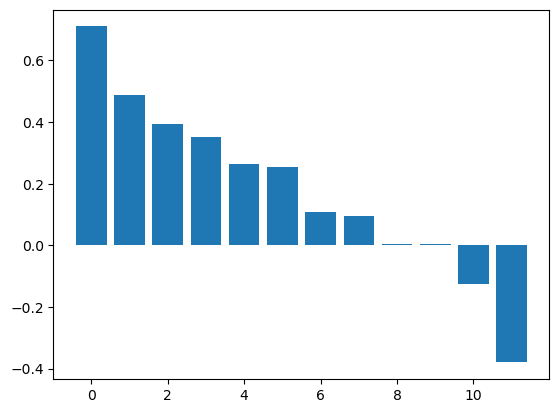

In [22]:
# get importance for logistic regression
importance = model.coef_[0]
indices = np.argsort(importance)[::-1]
for i,v in enumerate(zip(X.columns[indices], importance[indices])):
    print('Feature: {}  Score: {}' .format(i,v))

# plot feature importance
plt.bar([x for x in range(len(importance))], importance[indices])
plt.show()

## rough

In [23]:
works[works['cited_by_count']>200]

,doi,title,type,publication_date,host_venue,open_access_is_oa,open_access_oa_status,authorships,page_count,cited_by_count,concepts,referenced_works,abstract,counts_by_year
id,,,,,,,,,,,,,,
W2555618208,https://doi.org/10.1109/cvpr.2017.691,Multi-view 3D Object Detection Network for Aut...,proceedings-article,2017-07-21,V4306417987,True,green,"[[A2119051707, [I99065089]], [A2151001937, [I9...",-1,1409,"[[C131979681, 0.86888766], [C41008148, 0.77201...","[W7746136, W1536680647, W1914646313, W19466097...",This paper aims at high-accuracy 3D object det...,"[(2017, 13), (2018, 109), (2019, 308), (2020, ..."
W2557641257,https://doi.org/10.1109/cvpr.2017.733,ECO: Efficient Convolution Operators for Tracking,proceedings-article,2017-07-21,V4306417987,True,green,"[[A260882311, [I102134673]], [A2557978175, [I1...",-1,1322,"[[C63479239, 0.8030945], [C68339613, 0.7788200...","[W1857884451, W1892578678, W1904671147, W19157...","In recent years, Discriminative Correlation Fi...","[(2017, 9), (2018, 133), (2019, 303), (2020, 3..."
W2963709863,https://doi.org/10.1109/cvpr.2017.241,Learning from Simulated and Unsupervised Image...,proceedings-article,2017-07-21,V4306417987,True,green,"[[A2183241032, [I1311269955]], [A2798413642, [...",-1,1277,"[[C41008148, 0.8212265], [C2779803651, 0.78661...","[W1922126009, W1950149599, W1995694455, W20012...","With recent progress in graphics, it has becom...","[(2017, 55), (2018, 251), (2019, 356), (2020, ..."
W2594519801,https://doi.org/10.1109/cvpr.2017.261,ScanNet: Richly-Annotated 3D Reconstructions o...,proceedings-article,2017-07-21,V4306417987,True,green,"[[A2158018495, [I97018004]], [A2111957820, [I2...",-1,1116,"[[C41008148, 0.8516614], [C82990744, 0.6491697...","[W218762409, W1509835260, W1565402342, W159436...",A key requirement for leveraging supervised de...,"[(2017, 12), (2018, 76), (2019, 226), (2020, 3..."
W2561715562,https://doi.org/10.1109/cvpr.2017.215,CLEVR: A Diagnostic Dataset for Compositional ...,proceedings-article,2017-07-01,V4306417987,True,green,"[[A2345205178, [I97018004]], [A1988254826, [I2...",-1,1085,"[[C41008148, 0.7745689], [C130440534, 0.751482...","[W1933349210, W1983927101, W1996418862, W20646...",When building artificial intelligence systems ...,"[(2017, 38), (2018, 146), (2019, 232), (2020, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
W2964297864,https://doi.org/10.1109/iccv.2017.137,Adversarial PoseNet: A Structure-Aware Convolu...,proceedings-article,2017-04-30,V4306419272,True,green,"[[A2672142776, [I36399199]], [A2139473605, [I5...",-1,205,"[[C2779803651, 0.8591261], [C177769412, 0.8495...","[W1936750108, W1994529670, W2013640163, W20318...","For human pose estimation in monocular images,...","[(2017, 2), (2018, 36), (2019, 65), (2020, 48)..."
W2555428947,https://doi.org/10.18653/v1/d17-1039,Unsupervised Pretraining for Sequence to Seque...,proceedings-article,2017-09-01,V4306418267,True,hybrid,"[[A2953580041, [I157725225]], [A2551433269, [I...",-1,204,"[[C170858558, 0.8504702], [C203005215, 0.82808...","[W23305027, W1544827683, W1591801644, W1753482...",This work presents a general unsupervised lear...,"[(2017, 11), (2018, 40), (2019, 78), (2020, 40..."
W2963414781,https://doi.org/10.1109/asru.2017.8268935,"Exploring architectures, data and units for st...",proceedings-article,2017-12-01,V4306498158,True,green,"[[A2120260697, [I1291425158]], [A2639960128, [...",-1,204,"[[C41008148, 0.85740614], [C147168706, 0.82748...","[W1531333757, W1593247906, W2064675550, W21271...",We investigate training end-to-end speech reco...,"[(2017, 4), (2018, 27), (2019, 46), (2020, 62)..."


<AxesSubplot:xlabel='cited_by_count', ylabel='Count'>

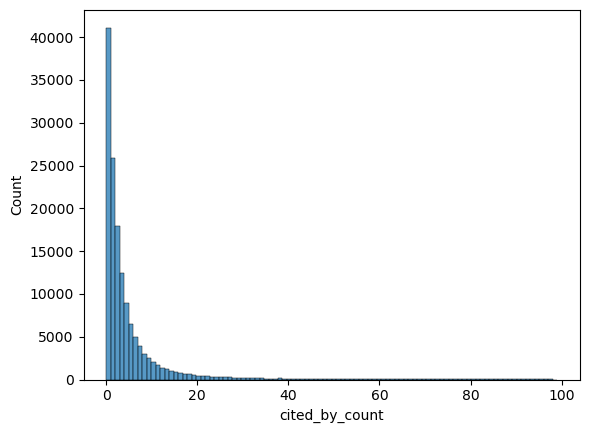

In [27]:
temp = works[works['cited_by_count']<100].reset_index()
sns.histplot(data=temp, x="cited_by_count", bins=100)

<AxesSubplot:xlabel='cited_by_count', ylabel='Count'>

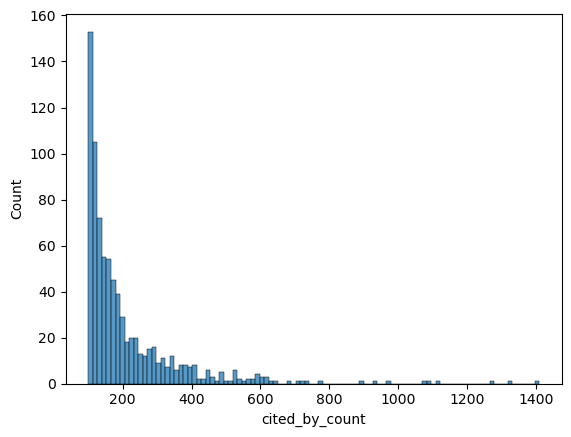

In [28]:
temp = works[works['cited_by_count']>100].reset_index()
sns.histplot(data=temp, x="cited_by_count", bins=100)